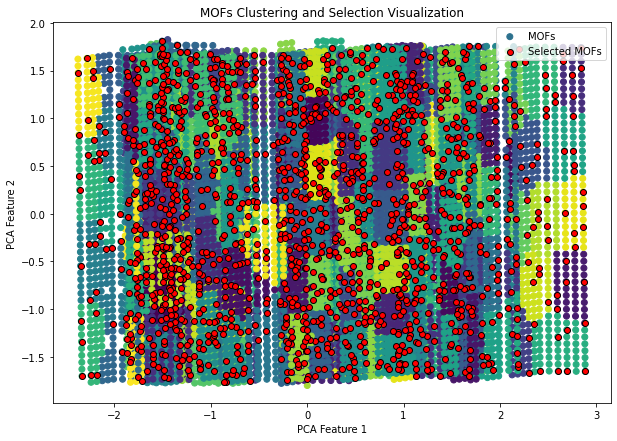

In [9]:
"""
This approach is used to build MOFs training sets of different sizes to fine-tune MOFS-LLM with supervision

This script performs clustering analysis on MOF materials data to select representative samples.
It reads MOF features from a CSV file, applies K-means clustering, reduces dimensionality using PCA,
visualizes the clusters and selected samples, and saves the selected MOF indices.

Key steps:
1. Load and preprocess MOF feature data
2. Perform K-means clustering
3. Reduce dimensions with PCA for visualization
4. Select representative samples from each cluster
5. Visualize results and save selected indices
"""

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

# Read CSV file
df = pd.read_csv('data/13515.csv')

# Prepare features for clustering
features = df[['node 1', 'node 2', 'edge', 'topo']]
features_encoded = features.apply(lambda x: pd.factorize(x)[0])

# Standardize feature data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_encoded)

# Initialize and perform clustering
n_clusters = 250
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

df['cluster'] = clusters

# Select data points from clusters
selected_indexes = []
for i in range(n_clusters):
    cluster_indexes = df[df['cluster'] == i].index.tolist()
    selected_indexes.extend(random.sample(cluster_indexes, 6))

# Plot all data points
plt.figure(figsize=(10, 7))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis', label='MOFs')

# Highlight selected points
selected_points = features_pca[selected_indexes]
plt.scatter(selected_points[:, 0], selected_points[:, 1], c='red', edgecolor='black', label='Selected MOFs')

# Set plot details
plt.title('MOFs Clustering and Selection Visualization')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()

# Save selected indices to CSV
selected_df = df.loc[selected_indexes]
selected_df['index'].to_csv('output/selected_mofs.csv', index=False)

准确率： 0.9481481481481482


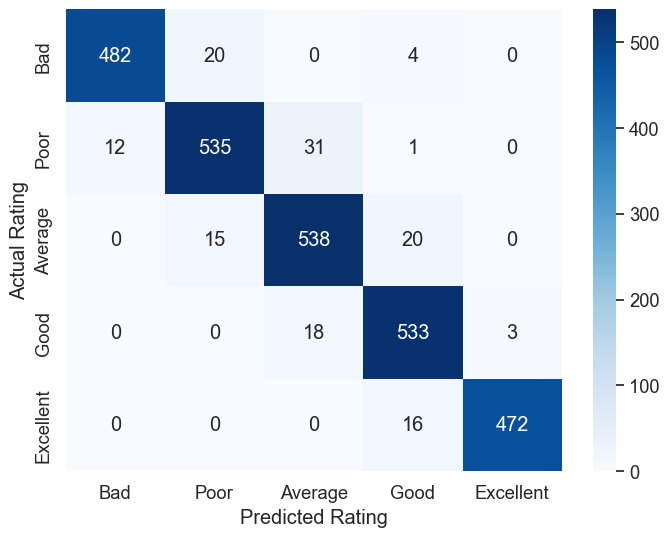

In [8]:
"""
This script analyzes the performance prediction results for MOF materials.
It reads response data from a JSONL file, compares predicted vs actual ratings,
calculates accuracy and visualizes the results using a confusion matrix.

The ratings are classified into 5 categories: Bad, Poor, Average, Good, Excellent.
"""

import json
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read responses and ratings from jsonl file
responses = []
ratings = []

# Define rating categories
rating_words = ['Bad', 'Poor', 'Average', 'Good', 'Excellent']

# Read and process the JSONL file
with open('Data\Performance prediction\MOFs-LLM-10566_data.jsonl', 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        record_list = json.loads(line)
        record = record_list[0]  

        # Extract response field
        response = record.get("response")
        if response:
            responses.append(response)
            # Extract rating
            completion_field = record.get("completion", "")
            rating = next((word for word in rating_words if word in completion_field), "")
            ratings.append(rating)

# Validate data
if len(responses) != len(ratings):
    raise ValueError("Responses and ratings don't match in length.")

# Map labels to integers for metrics calculation
label_to_int = {label: index for index, label in enumerate(rating_words)}
int_responses = [label_to_int[label] for label in responses if label in label_to_int]
int_ratings = [label_to_int[label] for label in ratings if label in label_to_int]

# Calculate accuracy
accuracy = accuracy_score(int_responses, int_ratings)
print("Accuracy:", accuracy)

# Plot confusion matrix
cm = confusion_matrix(int_responses, int_ratings)
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
           xticklabels=rating_words, yticklabels=rating_words)
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.show()